# Imports and Constants:

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos
from numpy import sin
from numpy import pi
from numpy import dot
from numpy import exp
from tqdm import trange, tqdm
import itertools
from pathos.multiprocessing import ProcessingPool as Pool
import os
import scienceplots
from cycler import cycler
plt.style.use(['science','ieee','notebook'])
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'})
plt.rcParams.update({
        'font.size': 21,
        'axes.labelsize': 21,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })
colors = ['#1F77B4', '#D62728', '#9467BD', 'gray','#17BECF', '#8C564B', '#E377C2', '#7F7F7F',  '#9A0EEA']

c=3e8
L=600 #meters
up_fold_angle = 0.42e-3 #radians
T=L/c

# Antenna Pattern Code:

In [38]:
def deltaT_folded(omega, theta, phi):
    thetahat = np.array([cos(theta)*cos(phi),cos(theta)*sin(phi),-sin(theta)])
    phihat = np.array([-sin(phi),cos(phi),0])
    
    eplus=np.outer(thetahat,thetahat)-np.outer(phihat,phihat)
    ecross=np.outer(thetahat,phihat)+np.outer(phihat,thetahat)
            
    xhat = np.array([1,0,0])
    xprimehat = np.array([cos(up_fold_angle),0,-sin(up_fold_angle)])
    yhat = np.array([0,1,0])
    yprimehat = np.array([0,cos(up_fold_angle),-sin(up_fold_angle)])
    nhat = np.array([sin(theta)*cos(phi),sin(theta)*sin(phi),cos(theta)])
    
    xxplus = dot(xhat, dot(eplus, xhat))
    xxcross = dot(xhat, dot(ecross, xhat))
    yyplus = dot(yhat, dot(eplus, yhat))
    yycross = dot(yhat, dot(ecross, yhat))
    
    xpxpplus = dot(xprimehat, dot(eplus, xprimehat))
    xpxpcross = dot(xprimehat, dot(ecross, xprimehat))
    ypypplus = dot(yprimehat, dot(eplus, yprimehat))
    ypypcross = dot(yprimehat, dot(ecross, yprimehat))
    
    dTout1xplus = (1/2*xxplus*1/(1.j*omega*(1+dot(xhat, nhat)))
                   *exp(-4.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(xhat,nhat)))-1))
    dTin1xplus = (1/2*xpxpplus*1/(1.j*omega*(1-dot(xprimehat, nhat)))
                   *exp(-3.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(xprimehat,nhat)))-1))
    dTout2xplus = (1/2*xpxpplus*1/(1.j*omega*(1+dot(xprimehat, nhat)))
                   *exp(-2.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(xprimehat,nhat)))-1))
    dTin2xplus = (1/2*xxplus*1/(1.j*omega*(1-dot(xprimehat, nhat)))
                   *exp(-1.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(xhat,nhat)))-1))
    dTxplus = dTout1xplus+dTin1xplus+dTout2xplus+dTin2xplus
    
    dTout1xcross = (1/2*xxcross*1/(1.j*omega*(1+dot(xhat, nhat)))
                   *exp(-4.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(xhat,nhat)))-1))
    dTin1xcross = (1/2*xpxpcross*1/(1.j*omega*(1-dot(xprimehat, nhat)))
                   *exp(-3.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(xprimehat,nhat)))-1))
    dTout2xcross = (1/2*xpxpcross*1/(1.j*omega*(1+dot(xprimehat, nhat)))
                   *exp(-2.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(xprimehat,nhat)))-1))
    dTin2xcross = (1/2*xxcross*1/(1.j*omega*(1-dot(xprimehat, nhat)))
                   *exp(-1.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(xhat,nhat)))-1))
    dTxcross = dTout1xcross+dTin1xcross+dTout2xcross+dTin2xcross
    
    
    dTout1yplus = (1/2*yyplus*1/(1.j*omega*(1+dot(yhat, nhat)))
                   *exp(-4.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(yhat,nhat)))-1))
    dTin1yplus = (1/2*ypypplus*1/(1.j*omega*(1-dot(yprimehat, nhat)))
                   *exp(-3.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(yprimehat,nhat)))-1))
    dTout2yplus = (1/2*ypypplus*1/(1.j*omega*(1+dot(yprimehat, nhat)))
                   *exp(-2.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(yprimehat,nhat)))-1))
    dTin2yplus = (1/2*yyplus*1/(1.j*omega*(1-dot(yprimehat, nhat)))
                   *exp(-1.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(yhat,nhat)))-1))
    dTyplus = dTout1yplus+dTin1yplus+dTout2yplus+dTin2yplus
    
    dTout1ycross = (1/2*yycross*1/(1.j*omega*(1+dot(yhat, nhat)))
                   *exp(-4.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(yhat,nhat)))-1))
    dTin1ycross = (1/2*ypypcross*1/(1.j*omega*(1-dot(yprimehat, nhat)))
                   *exp(-3.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(yprimehat,nhat)))-1))
    dTout2ycross = (1/2*ypypcross*1/(1.j*omega*(1+dot(yprimehat, nhat)))
                   *exp(-2.j*omega*L/c)*(exp(1.j*omega*L/c*(1+dot(yprimehat,nhat)))-1))
    dTin2ycross = (1/2*yycross*1/(1.j*omega*(1-dot(yprimehat, nhat)))
                   *exp(-1.j*omega*L/c)*(exp(1.j*omega*L/c*(1-dot(yhat,nhat)))-1))
    dTycross = dTout1ycross+dTin1ycross+dTout2ycross+dTin2ycross
    
    return dTxplus-dTyplus, dTxcross-dTycross

deltaT_folded_vec = np.vectorize(deltaT_folded)

# RMS Sky-averaging code:

In [39]:
def deltaT_folded_averaged_iter(omega):
    phi_range = np.linspace(0, 2*np.pi, 23, endpoint=False)
    theta_range = np.linspace(0, np.pi, 25, endpoint=False)
    
    deltaTsplusShape = np.zeros((len(theta_range), len(phi_range)))
    
    # Generate all combinations of (theta, phi, psi, phi0)
    all_combinations = list(itertools.product(theta_range, phi_range))

    # Define a function to compute deltaT_folded for a given set of parameters
    def wrapper(omega, theta, phi):
        return deltaT_folded(omega, theta, phi)

    # Use list comprehension to call deltaT_folded for all combinations
    results = np.array([wrapper(omega, theta, phi) for theta, phi in all_combinations])
    
    # Reshape the results into the original 4D shape
    deltaTsplus = results[:, 0].reshape(len(theta_range), len(phi_range))
    deltaTscross = results[:, 1].reshape(len(theta_range), len(phi_range))
    
    # Integration over the parameter space
    deltatheta = theta_range[1] - theta_range[0]
    deltaphi = phi_range[1] - phi_range[0]
    
    # Calculate the sin(theta) factor
    first_indices = np.arange(deltaTsplusShape.shape[0])
    factors = sin(theta_range[first_indices]).reshape(-1, 1)
    
    # Perform the summation
    deltaT_combined_sum = np.sum((np.abs(deltaTsplus)**2 + np.abs(deltaTscross)**2) * factors * deltatheta * deltaphi) / (4 * np.pi)

    return np.sqrt(deltaT_combined_sum)/(4*L/c)

# Wrapper function to call deltaT_folded_averaged_iter
def worker_function(args):
    return deltaT_folded_averaged_iter(args)

def deltaT_folded_averaged_vec_iter(omega_array):
    
    # Number of cores to process (leaving one available)
    num_cores = os.cpu_count() - 1
    
    # Use Pool to parallelize the computation
    with Pool(num_cores) as pool:
        # Use tqdm to show progress bar for Pool.imap
        results = list(tqdm(pool.imap(worker_function, omega_array), total=len(omega_array), desc="Processing frequencies"))

    # Convert lists to numpy arrays
    return np.array(results)

# Run frequency-dependent folded AP simulation:

In [40]:
# Frequency range:
freq = np.logspace(0,6,100000)
omega = freq*2*pi

# Optionally run simulation code if uncommented:
# F_rms = deltaT_folded_averaged_vec_iter(omega)

# For frequency array of antenna patterns completely normal to detector:
# deltaT_GW_plus, _ = np.abs(deltaT_folded_vec(omega, 0, 0, 0))
# Fp_norm = np.abs(deltaT_GW_plus/(4*T))

# Save AP Array as NPZ file:

In [41]:
# Optionally save array value 
# np.savez(f'GEO_F_rms_100000_05.npz', 
#          freqs=freq, F_rms=np.abs(F_rms))

# Call and Graph Antenna Patterns:

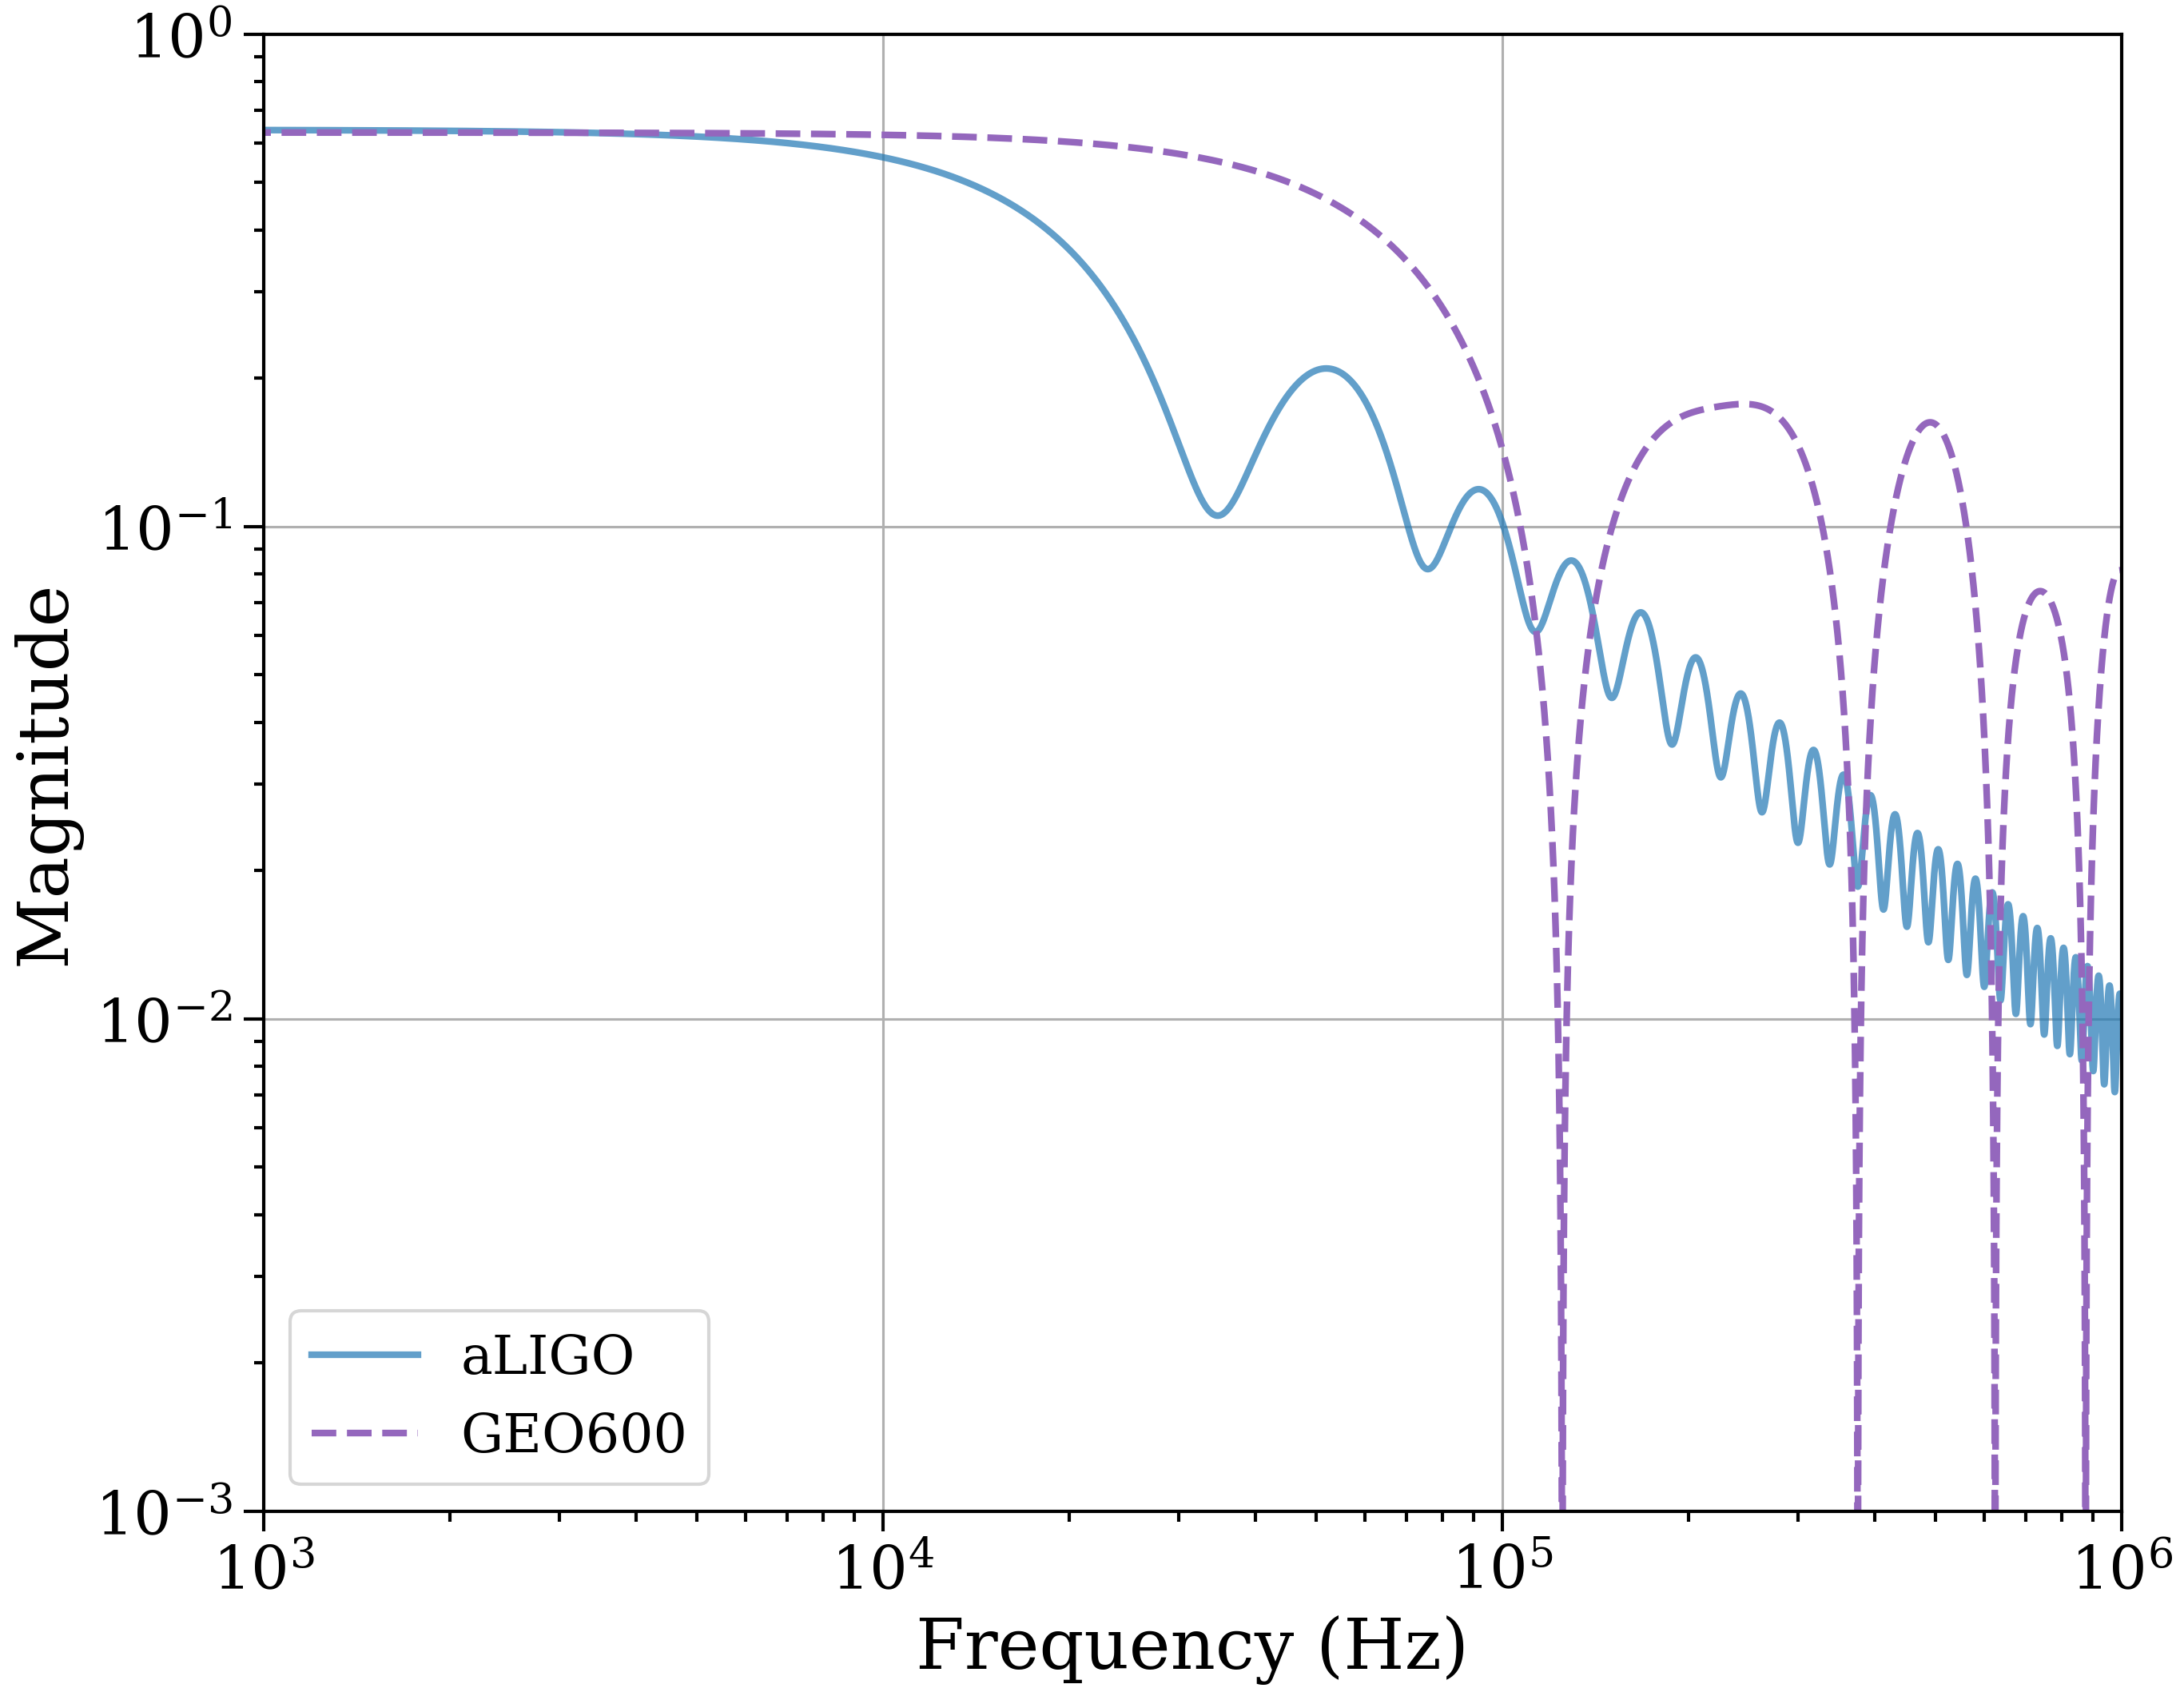

In [42]:
# Load in antenna-pattern arrays:
data = np.load('GEO_MI_F_rms_100000_06.npz')
data2 = np.load('GEO_F_rms_100000_06.npz')
data3 = np.load('LIGO_F_rms_100000_06.npz')
data4 = np.load('GEO_F_norm_100000_06.npz')

# Graph antenna patterns:
plt.figure(figsize=(10, 8))
plt.loglog(data3['freqs'], data3['F_rms'], label = r'aLIGO', color = colors[0], alpha=0.7)
# plt.loglog(data['freqs'], data['F_rms'], label = r'GEO600 unfolded', color = 'gray', alpha=0.7)
plt.loglog(data2['freqs'], data2['F_rms'], linestyle='dashed', label = r'GEO600', color = colors[2])
# plt.loglog(data4['freqs'], data4['Fp_norm'], linestyle='-.', label = r'$\left|F_+^{\text{fold}}\left(f, \hat{n} = \hat{z}\right)\right|$')

# Graph FSR and Half-FSR lines:
# for i in range(0,4):
#     plt.axvline(x=(3e8/(4*600)*(i)), color='gray', linestyle='dashed')
# plt.axvline(x=(3e8/(4*600)*(i+1)), color='gray', linestyle='dashed', label = r'$n\cdot\frac{c}{4(600)}$')
# for i in range(0,4):
#     plt.axvline(x=(3e8/(4*600)*(i+1/2)), color='black', linestyle='dashed')
# plt.axvline(x=(3e8/(4*600)*((i+1)+1/2)), color='black', linestyle='dashed', label = r'$(n+0.5)\cdot\frac{c}{4(600)}$')

plt.grid(True, which='major', linestyle='-', linewidth=0.75, zorder=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Magnitude')
plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)

plt.xlim(1e3,1e6)
plt.ylim(1e-3,1e0)
plt.legend(frameon=True, loc='lower left')

# plt.savefig('Antenna Pattern Plot.pdf',format='pdf', dpi=300)

plt.show()